In [1]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import poisson
import pymc3 as pm
import theano
from theano import tensor as T
from pymc3.math import switch
import matplotlib.pyplot as plt
import pandas as pd

# Blog example

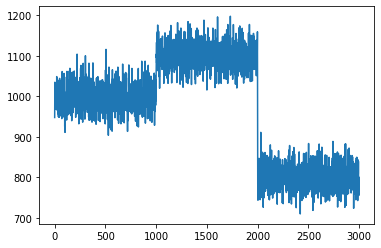

In [156]:
np.random.seed(100) #initialize random seed
size1 = 1000 #size of first part (number of points)
size2 = 1000 #size of second part (number of points)
size3 = 1000 #size of third part (number of points)
N = size1+size2+size3 #total number of points
scale = 30 #standard deviation of distribution function across all three parts
loc1 = 1000 #mean of normal for first part
loc2 = 1100 #mean of normal for second part
loc3 = 800 #mean of normal for third part
d1 = norm.rvs(loc=loc1,size=size1,scale=scale) #randomly generates points for first part
d2 = norm.rvs(loc=loc2,size=size2,scale=scale) #randomly generates points for second part
d3 = norm.rvs(loc=loc3,size=size3,scale=scale) #randomly generates points for third part
data = np.hstack([d1,d2,d3]) #these are our final observation points
plt.plot(data) #let's have a look at our data
plt.show()

The code above defines two changepoints at positions 1000 and 2000, in which the mean value changes from 1000 to 1100 and then from 1100 to 800. The standard deviation is set at the value 30 for the whole dataset.

Note that the changepoint variable $\tau_1$ and $\tau_2$ are initialized as uniform random variables. However, while $\tau_1$ spans the whole domain from 1 to $N$, where $N$ is the total number of data points, $\tau_2$ only span the values from $\tau_1$ to $N$. In this way, we ensure that $\tau_2 > \tau_1$. The switch function is used to achieve this property.

In [157]:
niter = 10000 #number of iterations for the MCMC algorithm
t = np.arange(0,N) #array of observation positions ('time')

with pm.Model() as model: # context management

    #define uniform priors
    mu1 = pm.Uniform("mu1",600,1200)
    mu2 = pm.Uniform("mu2",600,1200)
    mu3 = pm.Uniform("mu3",600,1200)
    sigma = pm.Uniform("sigma",1.e-3,100)
    tau1 = pm.DiscreteUniform("tau1",t.min(),t.max())
    tau2 = pm.DiscreteUniform("tau2",tau1,t.max())

    #define stochastic variable mu
    # _mu says that for all t that that is less than tau1, _mu takes the value of mu1.
    # Otherwise, _mu takes a value of mu2. In otherwords, for all t greater than tau1,
    # _mu will take a value of mu2. 
    _mu = T.switch(tau1>=t,mu1,mu2)
    mu = T.switch(tau2>=t,_mu,mu3)

    #define formula for log-likelihood
    # mu, sigma are the priors, data is the data created above.
    logp = - T.log(sigma * T.sqrt(2.0 * np.pi)) \
           - T.sqr(data - mu) / (2.0 * sigma * sigma)
    def logp_func(data):
        return logp.sum()

    #find out log-likelihood of observed data
    L_obs = pm.DensityDist('L_obs', logp_func, observed=data)

    #start MCMC algorithm
    #Increased tune to lower number of divergences.
    trace = pm.sample(niter, random_seed=123, tune=3000, progressbar=True, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sigma, mu3, mu2, mu1]
>CompoundStep
>>Metropolis: [tau2]
>>Metropolis: [tau1]
Sampling chain 1, 0 divergences: 100%|██████████████████████████████████████████| 13000/13000 [00:37<00:00, 349.10it/s]
The acceptance probability does not match the target. It is 0.9871716164287127, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9871317094828628, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


The plots on the right are plots of the data from two MCMC. Value is on the y-axis and time t is on the x-axis. Blue and orange represent two different markov chains. The right hand side plots indicate that the distribution has converged and is stationary. The plots on the left show the posterior distribution marginalized for each parameter.

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7813B2BA8>,
      dtype=object)

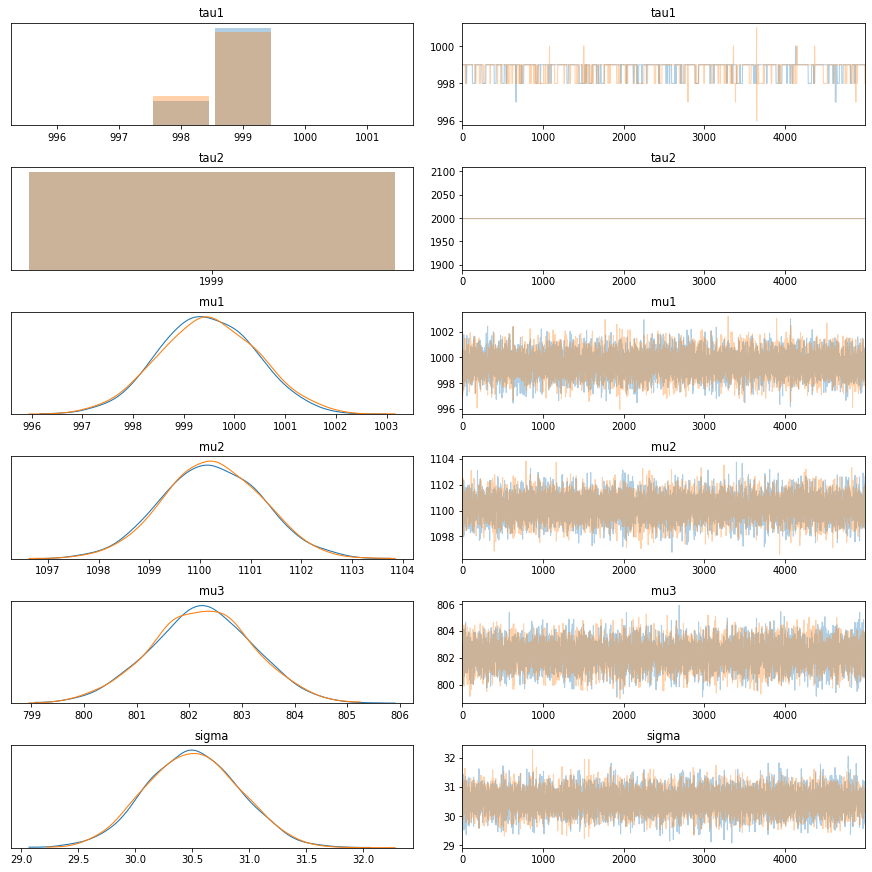

In [158]:
pm.traceplot(trace[5000:]) # Filtered out the first 5000 data points to ensure we only plot the converged chains.  

# Change points models Examples

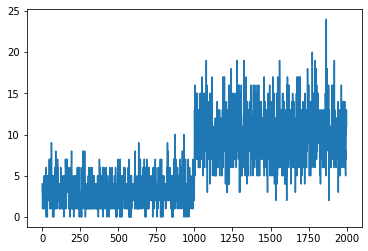

In [159]:
np.random.seed(100) #initialize random seed
size1 = 1000 #size of first part (number of points)
size2 = 1000 #size of second part (number of points)
N = size1+size2 #total number of points
lambda1 = 3 #mean of Poisson for first part
lambda2 = 10 #mean of Poisson for second part
d1 = poisson.rvs(mu=lambda1,size=size1) #randomly generates points for first part
d2 = poisson.rvs(mu=lambda2,size=size2) #randomly generates points for second part

data = np.hstack([d1,d2]) #these are our final observation points
plt.plot(data) #let's have a look at our data
plt.show()

In [160]:
niter = 2000 #number of iterations for the MCMC algorithm
t = np.arange(0,N) #array of observation positions ('time')

with pm.Model() as model: # context management

    #define exponential prior
    lda1 = pm.Exponential("lambda1", 1/data.mean())
    lda2 = pm.Exponential('lambda2', 1/data.mean())
    tau1 = pm.DiscreteUniform("tau1", t.min(), t.max())
    
    #define stochastic variable lambda
    lda = T.switch(tau1>=t, lda1, lda2)

    #find out log-likelihood of observed data
    L_obs = pm.Poisson('L_obs', lda, observed=data)
    
    #start MCMC algorithm
    trace = pm.sample(niter,random_seed=123, tune=2000, progressbar=True, cores=1)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\Norman\AppData\Local\Theano\compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_1_Stepping_1_AuthenticAMD-3.6.7-64\lock_dir\lock
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [lambda2, lambda1]
>Metropolis: [tau1]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 4000/4000 [00:04<00:00, 828.32it/s]
The number of effective samples is smaller than 25% for some parameters.


C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F78183ACC0>,
      dtype=object)

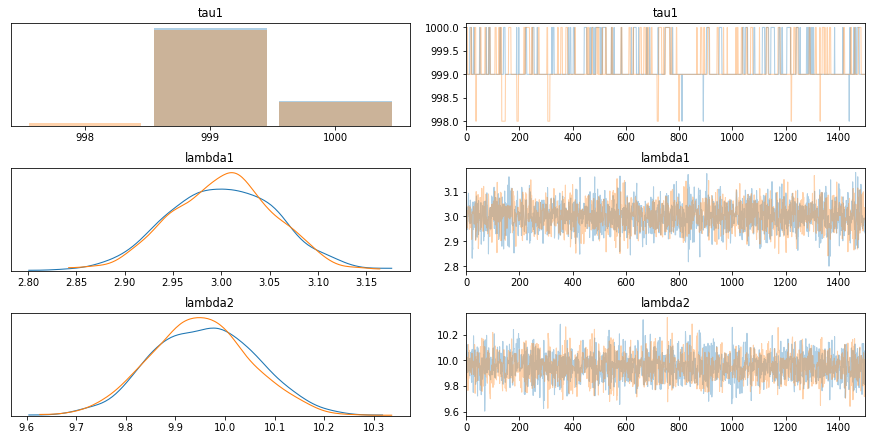

In [161]:
pm.traceplot(trace[500:]) # Filtered out the first 5000 data points to ensure we only plot the converged chains.  

In [162]:
niter = 3000 #number of iterations for the MCMC algorithm
t = np.arange(0,N) #array of observation positions ('time')

with pm.Model() as model: # context management

    #define exponential prior
    lda1 = pm.Exponential("lambda1", 1/data.mean())
    lda2 = pm.Exponential('lambda2', 1/data.mean())
    tau1 = pm.DiscreteUniform("tau1", t.min(), t.max())
    
    #define stochastic variable lambda
    lda = T.switch(tau1>=t, lda1, lda2)


    #define formula for log-likelihood3
    #Here we're using the log likelihood of the poisson distribution. 
    logp = (T.mul(T.log(lda), data)) - lda - T.log(T.gamma(T.add(data, 1.0)))
    def logp_func(data):
        return logp.sum()

    #find out log-likelihood of observed data
    #This is used to create a custom likelihood distribution. 
    L_obs = pm.DensityDist('L_obs', logp_func, observed=data)
    
    #start MCMC algorithm
    trace = pm.sample(niter,random_seed=123, tune=2000, progressbar=True, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [lambda2, lambda1]
>Metropolis: [tau1]
Sampling chain 1, 0 divergences: 100%|████████████████████████████████████████████| 5000/5000 [00:05<00:00, 968.74it/s]
The number of effective samples is smaller than 25% for some parameters.


C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7E9B31CC0>,
      dtype=object)

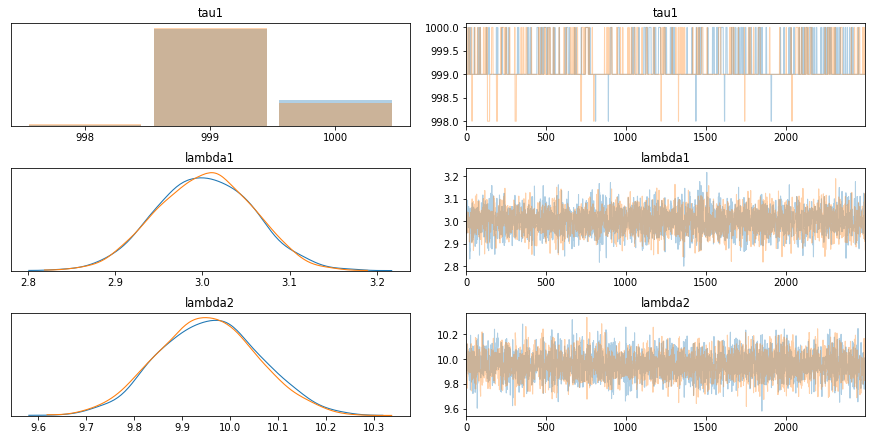

In [163]:
pm.traceplot(trace[500:]) # Filtered out the first 5000 data points to ensure we only plot the converged chains.  

# Homework 2 Problem 8

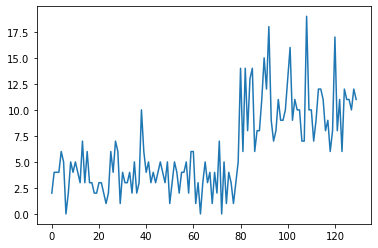

In [145]:
np.random.seed(100) #initialize random seed
data = pd.read_csv("change_point1.csv")['y']
N = len(data)
plt.plot(data) #let's have a look at our data
plt.show()

In [152]:
niter = 2000 #number of iterations for the MCMC algorithm
t = np.arange(0,N) #array of observation positions ('time')

with pm.Model() as model: # context management

    #define exponential prior
    lda1 = pm.Exponential("lambda1", 1/data.mean())
    lda2 = pm.Exponential('lambda2', 1/data.mean())
    tau1 = pm.DiscreteUniform("tau1", t.min(), t.max())
    
    #define stochastic variable lambda
    lda = T.switch(tau1>=t, lda1, lda2)

    #find out log-likelihood of observed data
    L_obs = pm.Poisson('L_obs', lda, observed=data)
    
    #start MCMC algorithm
    trace = pm.sample(niter,random_seed=123, tune=2000, progressbar=True, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [lambda2, lambda1]
>Metropolis: [tau1]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████| 4000/4000 [00:02<00:00, 1542.61it/s]
The number of effective samples is smaller than 25% for some parameters.


C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7F100DEF0>,
      dtype=object)

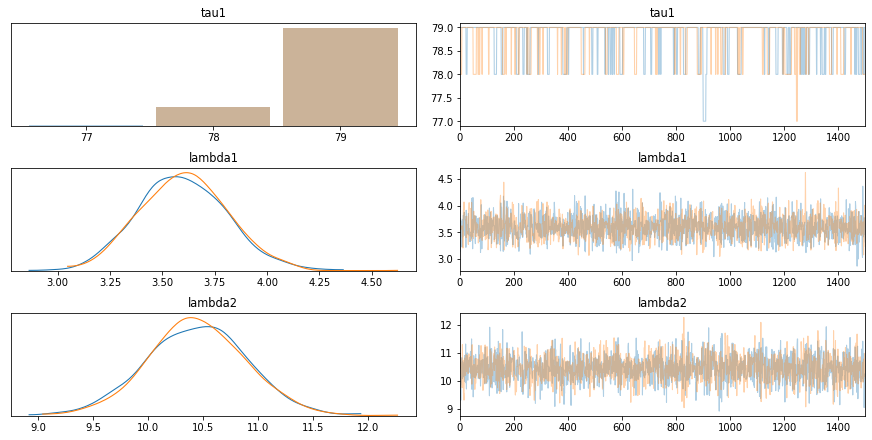

In [153]:
pm.traceplot(trace[500:]) # Filtered out the first 5000 data points to ensure we only plot the converged chains.  

In [150]:
niter = 3000 #number of iterations for the MCMC algorithm
t = np.arange(0,N) #array of observation positions ('time')

with pm.Model() as model: # context management

    #define exponential prior
    lda1 = pm.Exponential("lambda1", 1/data.mean())
    lda2 = pm.Exponential('lambda2', 1/data.mean())
    tau1 = pm.DiscreteUniform("tau1", t.min(), t.max())
    
    #define stochastic variable lambda
    lda = T.switch(tau1>=t, lda1, lda2)


    #define formula for log-likelihood3
    #Here we're using the log likelihood of the poisson distribution. 
    logp = (T.mul(T.log(lda), data)) - lda - T.log(T.gamma(T.add(data, 1.0)))
    def logp_func(data):
        return logp.sum()

    #find out log-likelihood of observed data
    #This is used to create a custom likelihood distribution. 
    L_obs = pm.DensityDist('L_obs', logp_func, observed=data)
    
    #start MCMC algorithm
    trace = pm.sample(niter,random_seed=123, tune=2000, progressbar=True, cores=1)

INFO (theano.gof.compilelock): Refreshing lock C:\Users\Norman\AppData\Local\Theano\compiledir_Windows-10-10.0.18362-SP0-AMD64_Family_23_Model_1_Stepping_1_AuthenticAMD-3.6.7-64\lock_dir\lock
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [lambda2, lambda1]
>Metropolis: [tau1]
Sampling chain 1, 0 divergences: 100%|███████████████████████████████████████████| 5000/5000 [00:03<00:00, 1580.18it/s]
The number of effective samples is smaller than 25% for some parameters.


C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F7F11AEA58>,
      dtype=object)

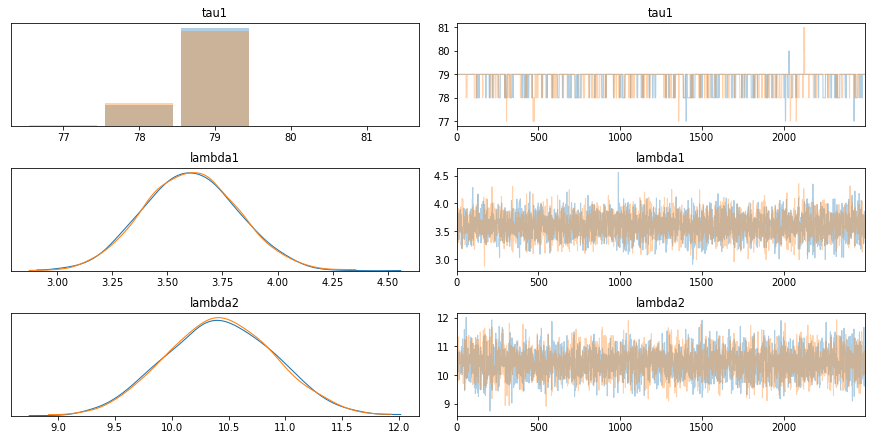

In [151]:
pm.traceplot(trace[500:]) # Filtered out the first 5000 data points to ensure we only plot the converged chains.  

# Homework 2 Problem 8 Optional

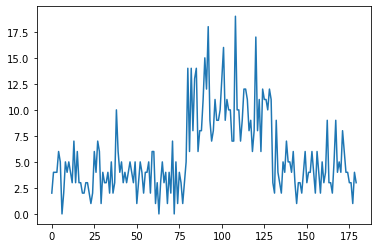

In [164]:
np.random.seed(100) #initialize random seed
data = pd.read_csv("change_point2.csv")['y']
N = len(data)
plt.plot(data) #let's have a look at our data
plt.show()

In [168]:
niter = 4000 #number of iterations for the MCMC algorithm
t = np.arange(0,N) #array of observation positions ('time')

with pm.Model() as model: # context management

    #define exponential prior
    lda1 = pm.Exponential("lambda1", 1/data.mean())
    lda2 = pm.Exponential('lambda2', 1/data.mean())
    lda3 = pm.Exponential('lambda3', 1/data.mean())
    tau1 = pm.DiscreteUniform("tau1", t.min(), t.max())
    tau1 = pm.DiscreteUniform("tau2", tau1, t.max())
    
    #define stochastic variable lambda
    #define stochastic variable mu
    # _mu says that for all t that that is less than tau1, _mu takes the value of mu1.
    # Otherwise, _mu takes a value of mu2. In otherwords, for all t greater than tau1,
    # _mu will take a value of mu2. 
    _lda = T.switch(tau1>=t,lda1,lda2)
    lda = T.switch(tau1>=t, _lda, lda3)


    #define formula for log-likelihood3
    #Here we're using the log likelihood of the poisson distribution. 
    logp = (T.mul(T.log(lda), data)) - lda - T.log(T.gamma(T.add(data, 1.0)))
    def logp_func(data):
        return logp.sum()

    #find out log-likelihood of observed data
    #This is used to create a custom likelihood distribution. 
    L_obs = pm.DensityDist('L_obs', logp_func, observed=data)
    
    #start MCMC algorithm
    trace = pm.sample(niter,random_seed=123, tune=3000, progressbar=True, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [lambda3, lambda2, lambda1]
>CompoundStep
>>Metropolis: [tau2]
>>Metropolis: [tau1]
Sampling chain 1, 1 divergences: 100%|████████████████████████████████████████████| 7000/7000 [00:07<00:00, 916.70it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F782FFED30>,
      dtype=object)

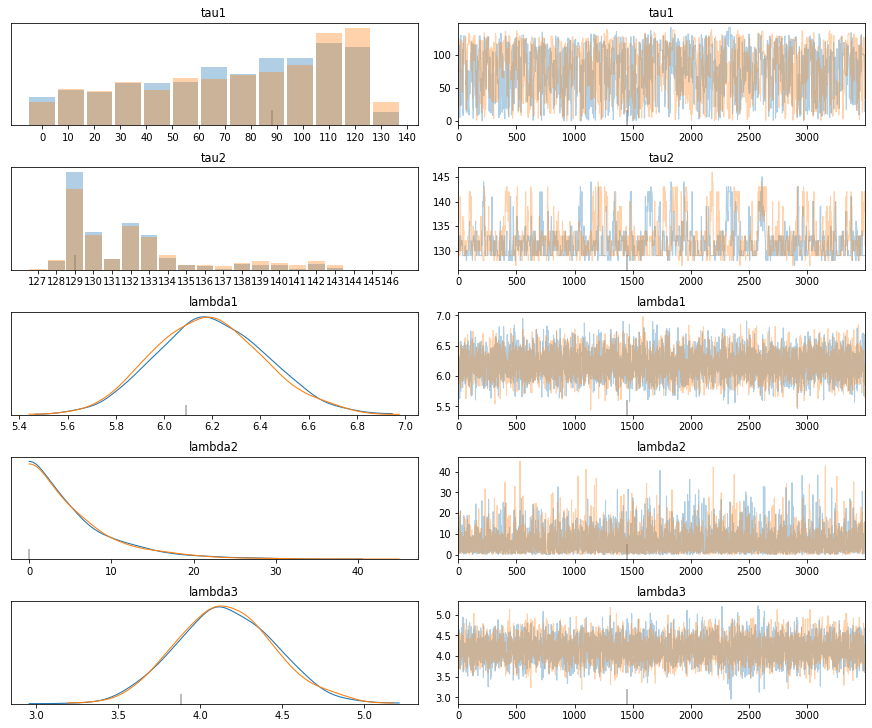

In [169]:
pm.traceplot(trace[500:]) # Filtered out the first 5000 data points to ensure we only plot the converged chains.  

# Homework 2 Problem 9

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import pymc3
from pymc3 import get_data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

In [3]:
# radon data
radon = pd.read_csv("radon.csv")
radon.columns = radon.columns.map(str.strip)
radon['fips'] = radon['stfips']*1000 + radon['cntyfips']
cty = pd.read_csv(get_data('cty.dat'))

In [4]:
# create a lookup table for each unique county. Used for indexing.
radon['county'] = radon['county'].map(str.strip)
counties = radon['county'].unique()
num_counties = len(counties)
county_lookup = dict(zip(counties, range(num_counties)))

In [5]:
# Assign data to variables
county = radon['county_code'] = radon['county'].replace(county_lookup).values
activity = radon['activity']
radon['log_radon'] = log_activity = np.log(activity + .01).values
floor_measure = radon['floor'].values
n = len(radon) # number of rows

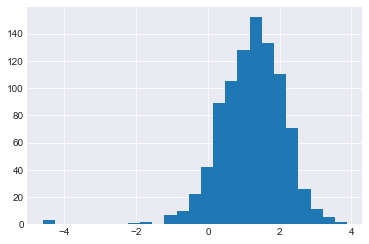

In [6]:
# Distribution of log radon activity
activity.apply(lambda x: np.log(x+.01)).hist(bins=25)

In [7]:
# Calculating the point estimates of the slope and intercept
# for complete pooling model using bayesian method.
from pymc3 import Model, sample, Normal, HalfCauchy, Uniform, model_to_graphviz

floor = radon.floor.values
log_radon = radon.log_radon.values

with Model() as pooled_model:

    beta = Normal('beta', 0, sigma=1e5, shape=2)
    sigma = HalfCauchy('sigma', 5)

    theta = beta[0] + beta[1]*floor

    y = Normal('y', theta, sigma=sigma, observed=log_radon)

# model_to_graphviz(pooled_model) --> having issues

In [8]:
with pooled_model:
    pooled_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta]
Sampling 4 chains, 0 divergences: 100%|███████████████████████████████████████| 8000/8000 [00:05<00:00, 1557.03draws/s]


In [9]:
# getting alpha and beta coefficients for pooled model.
alpha, beta = pooled_trace['beta'].mean(axis=0)

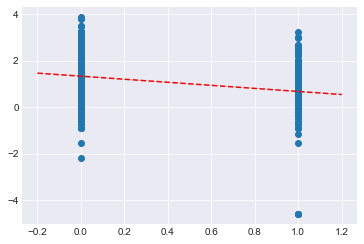

In [10]:
plt.scatter(radon.floor, np.log(activity + .01))
xvals = np.linspace(-.2, 1.2)
plt.plot(xvals, alpha+beta*xvals, 'r--')

In [14]:
# Creating unpooled model using bayesian framework.
with Model() as unpooled_model:

    beta0 = Normal('beta0', 0, sigma=1e5, shape=num_counties)
    beta1 = Normal('beta1', 0, sigma=1e5)
    sigma = HalfCauchy('sigma', 5)

    theta = beta0[county] + beta1*floor

    y = Normal('y', theta, sigma=sigma, observed=log_radon)
# model_to_graphviz(unpooled_model)

In [15]:
with unpooled_model:
    unpooled_trace = sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|████████████████████████████████████████| 8000/8000 [00:08<00:00, 975.18draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016D25542E10>],
      dtype=object)

<Figure size 432x1008 with 0 Axes>

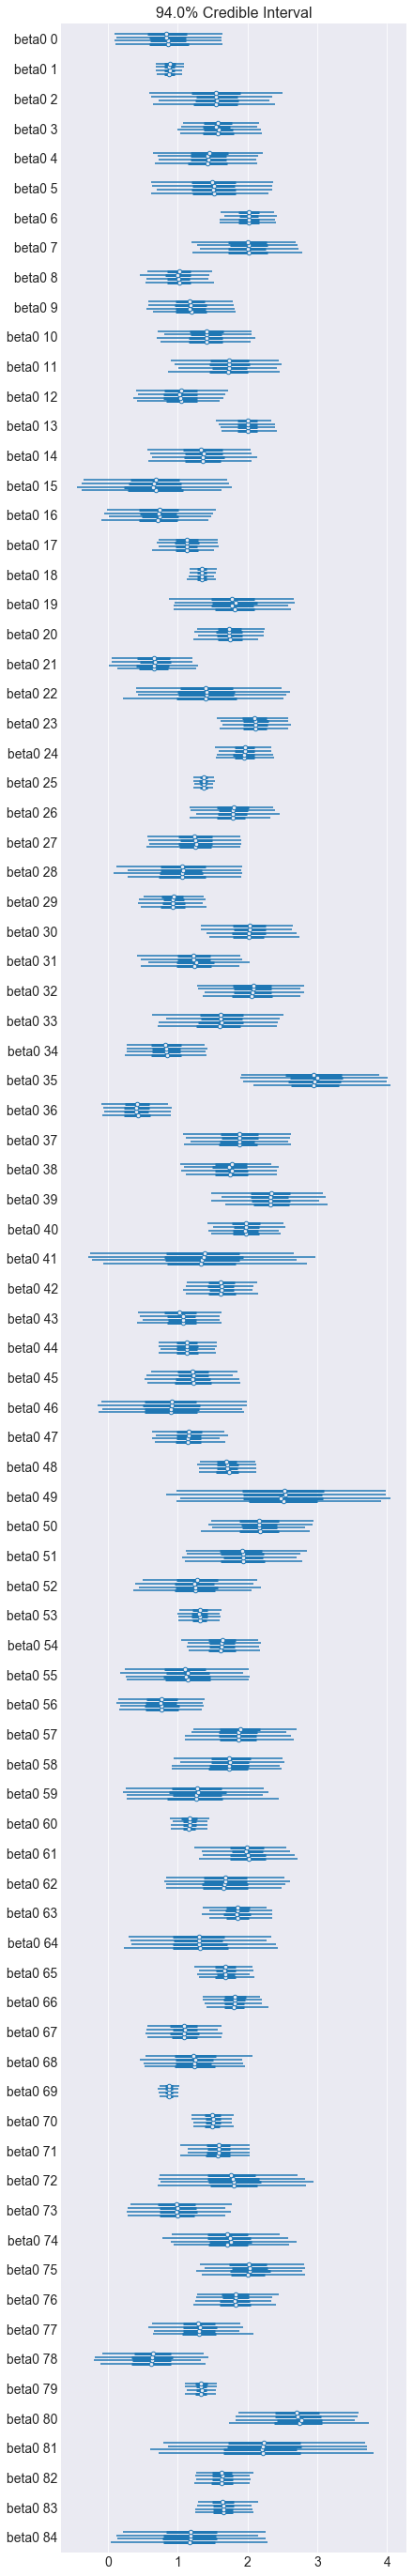

In [16]:
from pymc3 import forestplot

# These are the alpha coefficients for the unpooled model with credible interval. 
plt.figure(figsize=(6,14))
forestplot(unpooled_trace, var_names=['beta0'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000016D26346588>],
      dtype=object)

<Figure size 432x1008 with 0 Axes>

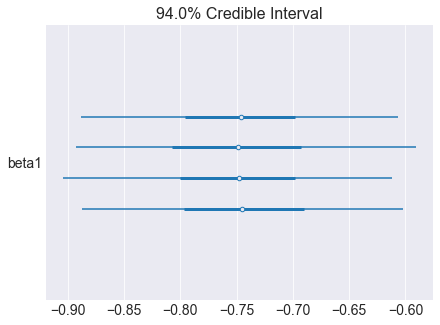

In [27]:
# This is the beta coefficient for the unpooled model with credible interval. 
# There are 4 coefficients because there are 4 markov chains in the simulation.
plt.figure(figsize=(6,14))
forestplot(unpooled_trace, var_names=['beta1'])

In [18]:
# beta0 is the alpha estimate for unpooled model.
unpooled_estimates = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=counties)
unpooled_se = pd.Series(unpooled_trace['beta0'].std(axis=0), index=counties)

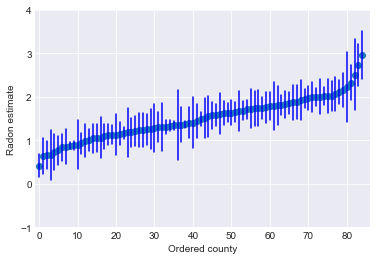

In [21]:
# Plot of alpha coefficient estimates for unpooled model and ordered from low to high. 
order = unpooled_estimates.sort_values().index

plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[order])
for i, m, se in zip(range(len(unpooled_estimates)), unpooled_estimates[order], unpooled_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

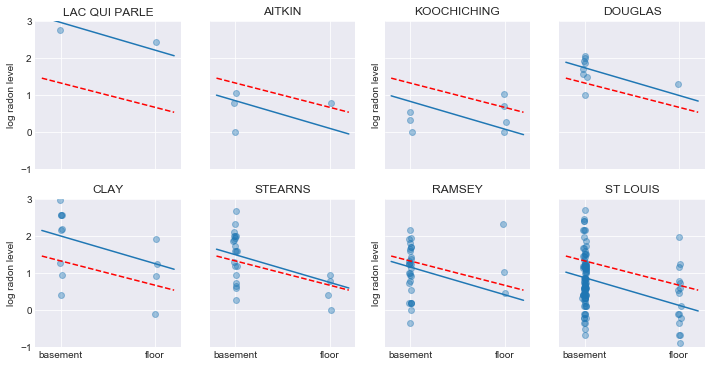

In [30]:
# Comparing pooled and unpooled model
# coefficient for individual models are plotted. 
# observatoins for a subset of counties are presented. 
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean() # calculating the average of beta from 4 markov chains and 1000 iterations.
for i,c in enumerate(sample_counties):
    y = radon.log_radon[radon.county==c]
    x = radon.floor[radon.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model --> intercept different for each county but slope is the same. 
    b = unpooled_estimates[c]

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b) # blue line unpooled model
    axes[i].plot(xvals, beta*xvals+alpha, 'r--') # red dashed line pooled model.
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

### Reason why above model is bad:
1. pooling model is useless if we're trying to identify high-radon counties.
2. Unpooled model produce extreme coefficient estimates because there are few observations.

# Partial pooling hierarchical models

In [48]:
with Model() as partial_pooling:

    # Priors
    mu_a = Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = HalfCauchy('sigma_a', 5)

    # Random intercepts
    a = Normal('a', mu=mu_a, sigma=sigma_a, shape=num_counties)
    # Common slope across counties
    b = Normal('b', mu=0., sigma=1e5)

    # Model error
    sigma_y = HalfCauchy('sigma_y',5)

    # Expected value
    y_hat = a[county] + b * floor_measure

    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)

# model_to_graphviz(partial_pooling)


In [59]:
with partial_pooling:
    partial_pooling_trace = sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_a, mu_a]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 12000/12000 [00:11<00:00, 1073.34draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [35]:
# a is the alpha estimate for partial pooled model.
partial_pooling_estimates = pd.Series(partial_pooling_trace['a'].mean(axis=0), index=counties)
partial_pooling_se = pd.Series(partial_pooling_trace['a'].std(axis=0), index=counties)

In [55]:
# b is the beta estimate for the partial pooled model. (slope)
partial_pooling_beta = partial_pooling_trace['b'].mean()

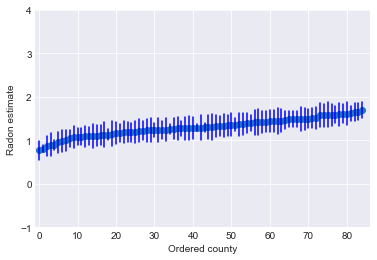

In [36]:
# Plot of alpha coefficient estimates for unpooled model and ordered from low to high. 
order = partial_pooling_estimates.sort_values().index

plt.scatter(range(len(partial_pooling_estimates)), partial_pooling_estimates[order])
for i, m, se in zip(range(len(partial_pooling_estimates)), partial_pooling_estimates[order], partial_pooling_se[order]):
    plt.plot([i,i], [m-se, m+se], 'b-')
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate');plt.xlabel('Ordered county');

In [38]:
partial_pooling_estimates.sort_values()

LAKE           0.767067
ST LOUIS       0.808007
KOOCHICHING    0.866325
COTTONWOOD     0.896520
ANOKA          0.898387
                 ...   
NICOLLET       1.614983
CLAY           1.617101
FREEBORN       1.657035
GOODHUE        1.660488
BLUE EARTH     1.702913
Length: 85, dtype: float64

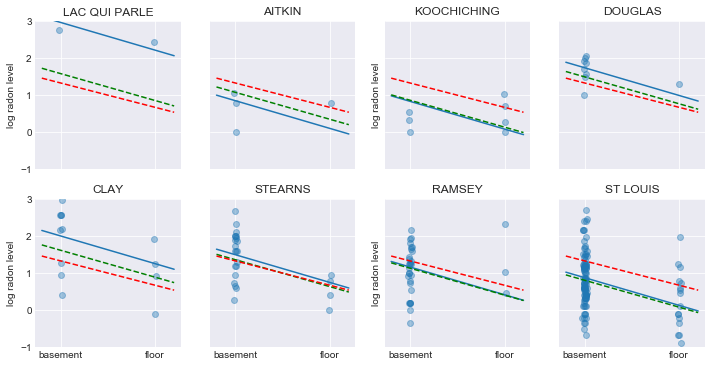

In [56]:
# Comparing pooled, unpooled model, and partial pooling model
# coefficient for individual models are plotted. 
# observatoins for a subset of counties are presented. 
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING',
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace['beta1'].mean() # calculating the average of beta from 4 markov chains.
for i,c in enumerate(sample_counties):
    y = radon.log_radon[radon.county==c]
    x = radon.floor[radon.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)

    # No pooling model --> intercept different for each county but slope is the same. 
    b = unpooled_estimates[c]
    partial_b = partial_pooling_estimates[c]

    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[i].plot(xvals, m*xvals+b) # blue line unpooled model
    axes[i].plot(xvals, xvals*partial_pooling_beta + partial_b, 'g--') # green line partial pooled model
    axes[i].plot(xvals, beta*xvals+alpha, 'r--') # red dashed line pooled model.
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Norman\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument bac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000016D32ABDD30>,
      dtype=object)

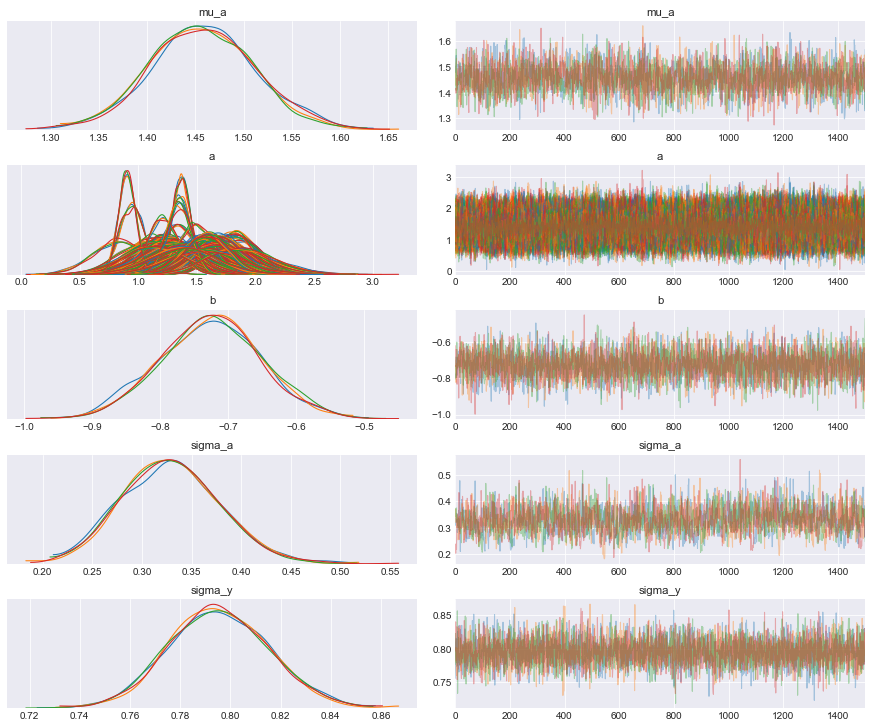

In [61]:
pm.traceplot(partial_pooling_trace[500:]) # Filtered out the first 500 data points to ensure we only plot the converged chains.  